In [1]:
import math
import itertools
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', None)
!pip install pmdarima
import pmdarima as pm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
BASE_DRIVE_PATH = "/content/drive/MyDrive/Trabajo profesional"

Mounted at /content/drive


In [3]:
data = pd.read_csv(BASE_DRIVE_PATH + "/Code/data/prod_split_train_2024-05-28_15:05:17.csv", index_col=0, low_memory=False)
data["fecha"] = pd.to_datetime(data["fecha"])
data.sort_values(by=['fecha', 'idpozo'], ascending=True, inplace=True)
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134850 entries, 0 to 134849
Data columns (total 35 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   idempresa                134850 non-null  object        
 1   fecha                    134850 non-null  datetime64[ns]
 2   periodo                  134850 non-null  int64         
 3   anio                     134850 non-null  int64         
 4   mes                      134850 non-null  int64         
 5   prod                     134850 non-null  float64       
 6   idpozo                   134850 non-null  int64         
 7   tipopozo                 134850 non-null  object        
 8   prod_pet                 134850 non-null  float64       
 9   prod_gas                 134850 non-null  float64       
 10  prod_agua                134850 non-null  float64       
 11  tef                      134850 non-null  float64       
 12  tipoextraccion  

### El pozo 159635 tiene datos para la mayoría del intervalo

In [4]:
def get_prod_by_well_id(id):
  return data[data["idpozo"] == id][["idpozo", "fecha", "prod_pet", "prod_gas"]]

def plot_well_id(id):
  fig, axes = plt.subplots(nrows=1, ncols=2)
  fig.set_size_inches(20, 6)
  well_prod = data[data["idpozo"] == id]
  well_prod.plot(ax=axes[0], x="fecha", y="prod_pet", title=f"Producción de petroleo #{id}", grid=True, ylabel="m3")
  well_prod.plot(ax=axes[1], x="fecha", y="prod_gas", title=f"Producción de gas #{id}", grid=True, ylabel="miles de m3")

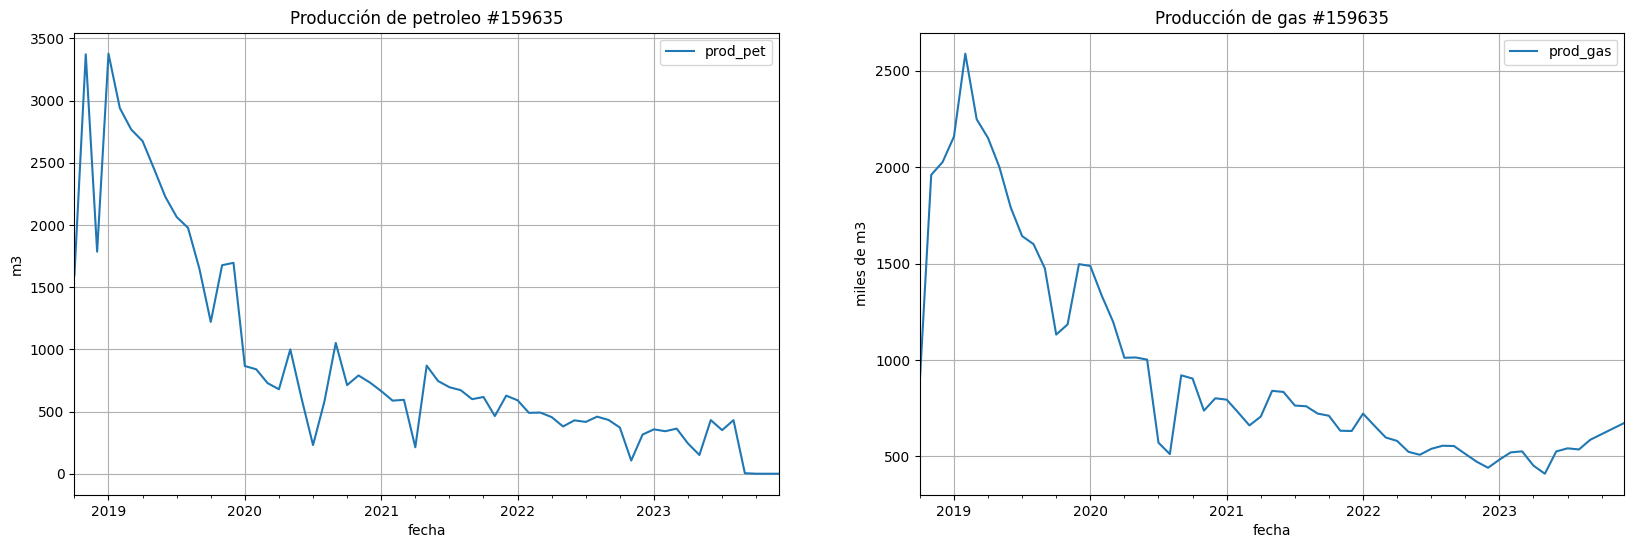

In [5]:
PEEK_WELL_ID = 159635
plot_well_id(PEEK_WELL_ID)

# ARIMA

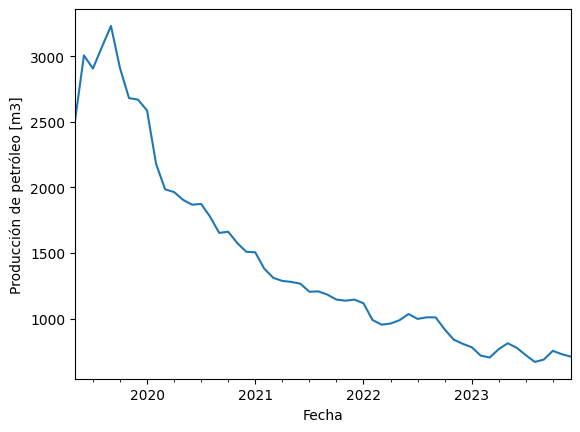

In [6]:
PEEK_WELL_ID = 160332
peek_data = get_prod_by_well_id(PEEK_WELL_ID)[['fecha', 'prod_pet']].set_index('fecha')
peek_data.plot(ylabel="Producción de petróleo [m3]", xlabel="Fecha", legend="")
plt.show()

### Reducción de "ruido blanco"

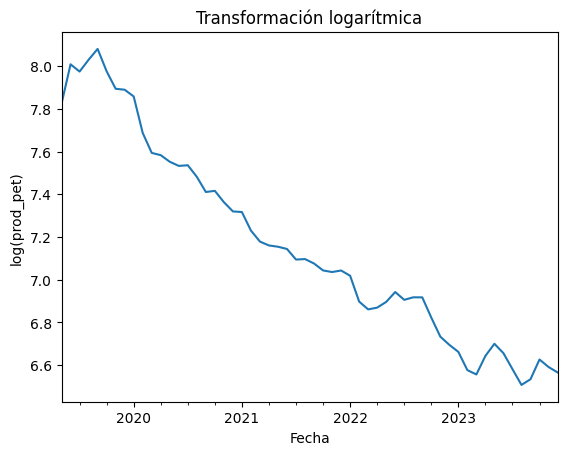

In [7]:
# primero achicamos la escala con log
peek_data_log = np.log(peek_data)
peek_data_log.plot(ylabel="log(prod_pet)", xlabel="Fecha", legend="", title="Transformación logarítmica")
plt.show()

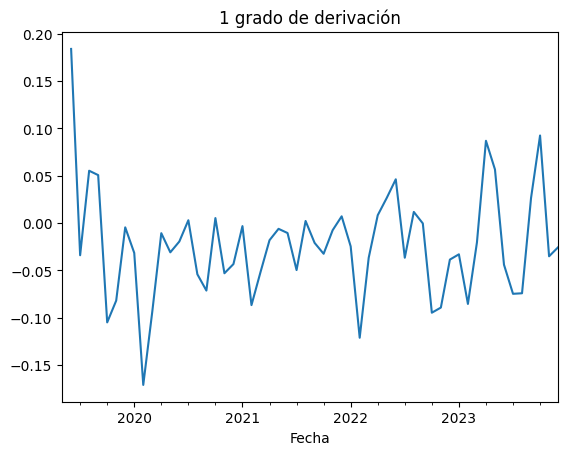

In [8]:
# realizamos un primer nivel de derivación
peek_data_log_diff=peek_data_log.diff(1)
peek_data_log_diff.plot(ylabel="", xlabel="Fecha", legend="", title="1 grado de derivación")
plt.show()

### Vemos si es una serie estacionaria

In [9]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12, center=True).mean()
    rolstd = timeseries.rolling(12, center=True).std()

    # Plot rolling statistics:
    plt.plot(rolstd, color='red', label='Rolling Standard Deviation')
    plt.plot(rolmean, color='blue', label='Rolling Mean')
    plt.plot(timeseries, color='dimgray', label='Original')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(rotation=40)
    plt.legend(loc='best')
    plt.show()

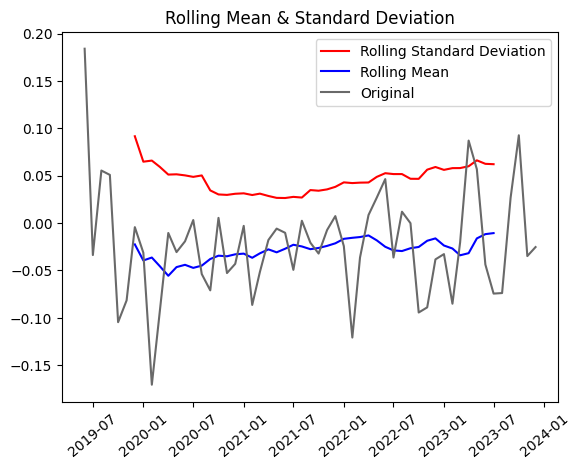

In [10]:
test_stationarity(peek_data_log_diff)

### Aplicación del modelo ARIMA

In [11]:
# TAKES LONG TIME
# TAKES LONG TIME
# TAKES LONG TIME
# TAKES LONG TIME

# peek_data_log_diff.index = pd.DatetimeIndex(peek_data_log_diff.index).to_period('M')
# peek_data_log_diff = peek_data_log_diff.dropna()
# model = ARIMA(peek_data_log_diff, order=(1, 1, 2))
# results_ARIMA = model.fit()
# plt.plot(peek_data_log_diff)
# plt.plot(results_ARIMA.fittedvalues, color='red')
# plt.plot(results_ARIMA.predict(), color='black')
# plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-peek_data_log_diff)**2))
# plt.title('R square: %.2f'% r2_score(peek_data_log_diff, results_ARIMA.predict()))

### Aplicación del modelo AUTO-ARIMA

In [12]:
MONTHS_TO_PREDICT = 3

def predict_by_arima(series_data, months_to_predict, aggregate_full_series=pd.DataFrame(), debug=False):
  model = pm.auto_arima(
            series_data,
            X=None if aggregate_full_series.empty else aggregate_full_series.head(len(series_data)).values.reshape(-1, 1),
            m=1,                  # frequency of series
            seasonal=False,       # TRUE if seasonal series
            d=None,               # let model determine 'd'
            test='adf',           # use adftest to find optimal 'd'
            start_p=0, start_q=0, # minimum p and q
            max_p=12, max_q=12,   # maximum p and q
            D=None,               # let model determine 'D'
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=False,
            random=False,
            #out_of_sample_size=months_to_predict
  )

  if debug:
    print(model.summary())

  fc, confint = model.predict(
      n_periods=months_to_predict,
      X=None if aggregate_full_series.empty else aggregate_full_series.head(len(series_data) + months_to_predict).tail(months_to_predict).values.reshape(-1, 1),
      return_conf_int=True)

  fc = pd.DataFrame(fc)
  fc.columns = fc.columns.astype(str)
  fc.columns.values[0] = "predicted_prod_pet"
  fc["predicted_prod_pet"] = fc["predicted_prod_pet"].map(lambda x: x if x > 0.0 else 0.0)
  #fc.index = series_data.tail(months_to_predict).index

  if debug:
    print(fc)

  return fc, confint

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=988.458, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=1.55 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=1.72 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=1.90 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=695.085, Time=0.39 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.63 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=1.76 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=1.99 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.64 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.75 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.95 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=1.18 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,

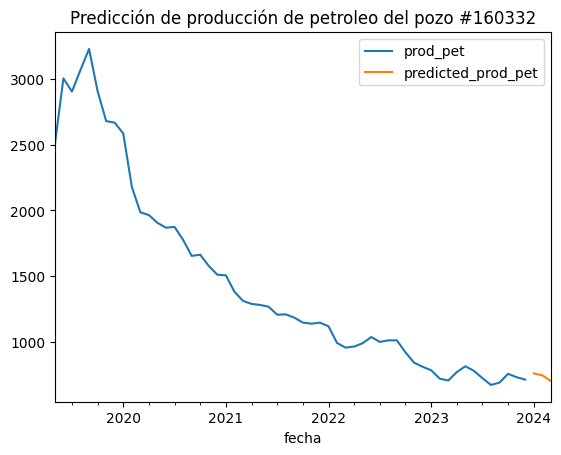

In [13]:
well_prod = get_prod_by_well_id(PEEK_WELL_ID)[['fecha', 'prod_pet']].set_index('fecha')
well_prod.index = pd.DatetimeIndex(well_prod.index).to_period('M')
fc, confint = predict_by_arima(well_prod, MONTHS_TO_PREDICT)

well_prod = data[data["idpozo"] == PEEK_WELL_ID][['fecha', 'prod_pet']].set_index('fecha')
ax = well_prod.plot(title=f"Predicción de producción de petroleo del pozo #{PEEK_WELL_ID}")
fc.plot(ax=ax)
plt.show()

### Prediction using mean aggregate curve

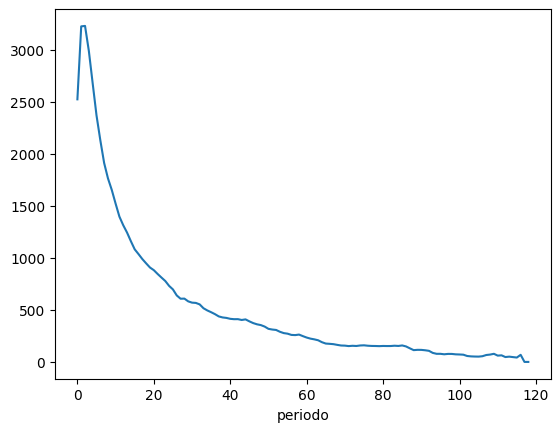

In [14]:
total_mean_prod = data.groupby(by="periodo")["prod_pet"].mean()
well_max = data[data["idpozo"] == PEEK_WELL_ID][['prod_pet']].max()[0]
mult_factor = well_max / total_mean_prod.max()
total_mean_prod_scaled = total_mean_prod*mult_factor
total_mean_prod_scaled.plot()
plt.show()

In [15]:
len_to_take = len(data[data["idpozo"] == PEEK_WELL_ID])
well_prod = total_mean_prod_scaled.head(len_to_take)
fc, confint = predict_by_arima(well_prod, MONTHS_TO_PREDICT)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=958.999, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=665.802, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=681.812, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=658.401, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=652.925, Time=0.18 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=653.071, Time=0.12 sec


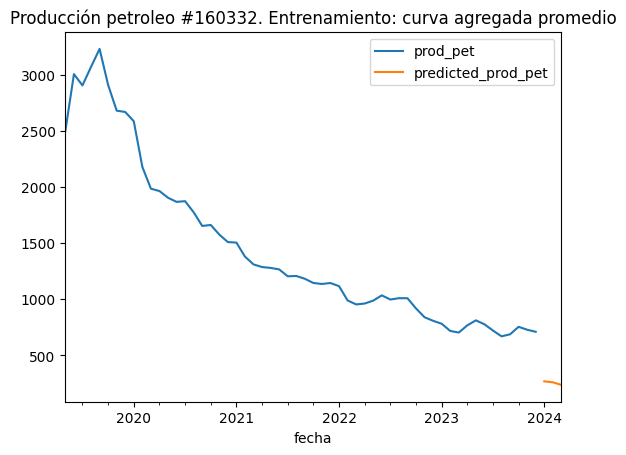

In [16]:
fc.index = data[data["idpozo"] == PEEK_WELL_ID].set_index("fecha").tail(MONTHS_TO_PREDICT).index.map(lambda i: i + pd.DateOffset(months=MONTHS_TO_PREDICT))
well_prod = data[data["idpozo"] == PEEK_WELL_ID][['fecha', 'prod_pet']].set_index('fecha')
ax = well_prod.plot(title=f"Producción petroleo #{PEEK_WELL_ID}. Entrenamiento: curva agregada promedio")
fc.plot(ax=ax)
plt.show()

### Apply "single well", "aggregate mean" and "grouped by areayacimiento mean" prediction for selected wells

In [17]:
all_areas_mean_prods = {}
areas = data["areayacimiento"].value_counts().index.to_list()

for area in areas:
  area_prod = data[data["areayacimiento"] == area]
  wells_area_unique_count = len(area_prod["idpozo"].value_counts())
  all_areas_mean_prods[area] = area_prod.groupby(by="periodo")[["prod_pet", "prod_gas"]].mean()
  all_areas_mean_prods[area].plot(title=f"{area} ({wells_area_unique_count})")

Output hidden; open in https://colab.research.google.com to view.

In [18]:
def get_df_from_fc_and_confint(well_id, fc, confint):
  prediction_df = fc.reset_index().rename(columns={"index": "fecha", "predicted_prod_pet": "prod_pet"})
  prediction_df["idpozo"] = well_id
  confint_min, confint_max = np.split(confint, 2, axis=1)
  prediction_df["confint_min"] = [x[0] for x in confint_min]
  prediction_df["confint_max"] = [x[0] for x in confint_max]
  prediction_df = prediction_df[["fecha", "idpozo", "prod_pet", "confint_min", "confint_max"]]
  prediction_df["fecha"] = pd.to_datetime(prediction_df["fecha"].astype(str))
  return prediction_df

In [19]:
def predict_area_mean_prod(area, months):
  global all_areas_mean_prods

  fc, confint = predict_by_arima(all_areas_mean_prods[area][["prod_pet"]], months)
  df = fc.rename(columns={"predicted_prod_pet": "prod_pet"})
  return pd.concat([all_areas_mean_prods[area], df], ignore_index=True)


Running auto-arima on single well #158364 prediction

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1324.910, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1076.539, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1011.724, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1013.689, Time=0.27 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1041.683, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1013.562, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.37 sec


<ipython-input-21-5e103dc35849>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_mean_prod_norm["prod_pet"] = scaler.fit_transform(area_mean_prod_norm)


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1098.905, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1020.674, Time=0.31 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=975.799, Time=0.43 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=975.307, Time=0.30 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=973.923, Time=0.73 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=975.185, Time=0.44 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1019.679, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=976.521, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=972.812, Time=0.20 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=972.908, Time=0.29 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=974.605, Time=0.46 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=999.680, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=975.825, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=972.662, Time=0.33 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=976.834, Time=0.38 sec
 ARIMA(3,0,0)(0,0,0)[0

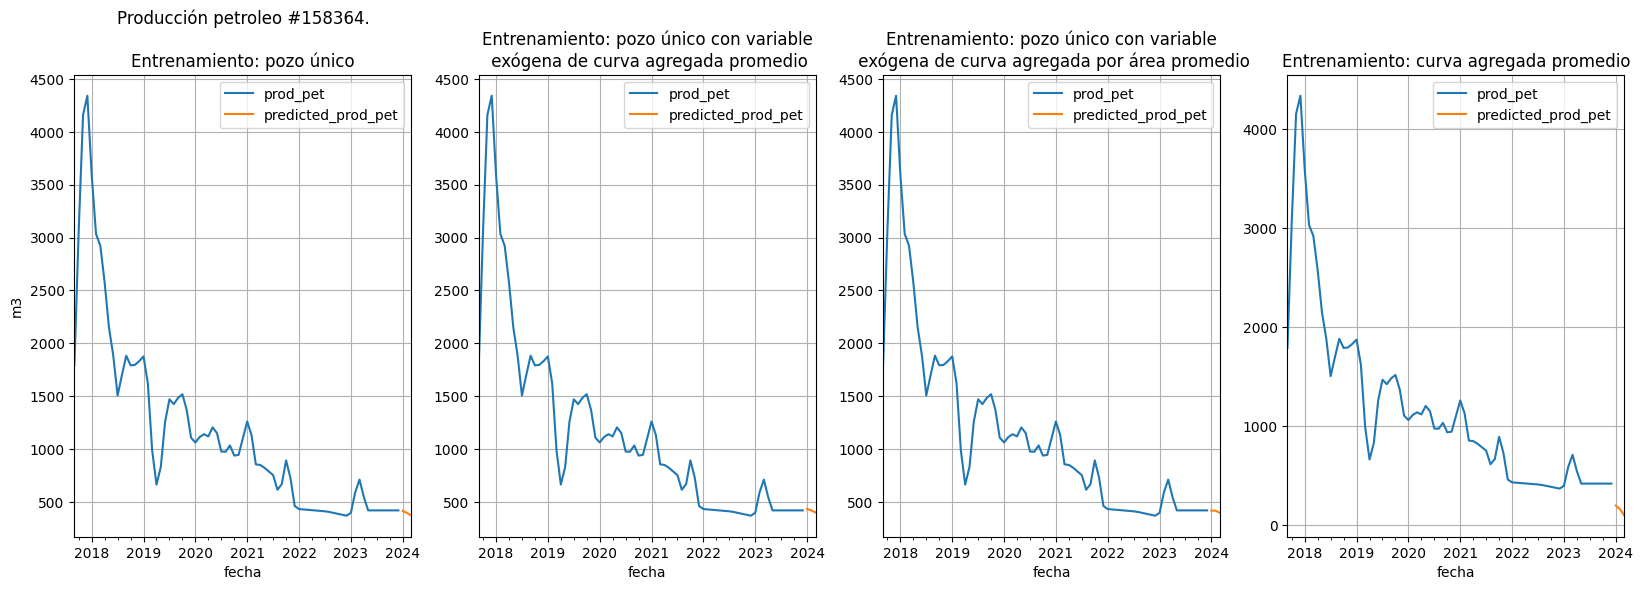


Running auto-arima on single well #160211 prediction

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1040.871, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.64 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=874.994, Time=0.62 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=858.616, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=855.545, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=857.024, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(3,0

<ipython-input-21-5e103dc35849>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_mean_prod_norm["prod_pet"] = scaler.fit_transform(area_mean_prod_norm)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=781.341, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=780.284, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=786.370, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=779.930, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=781.894, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARI

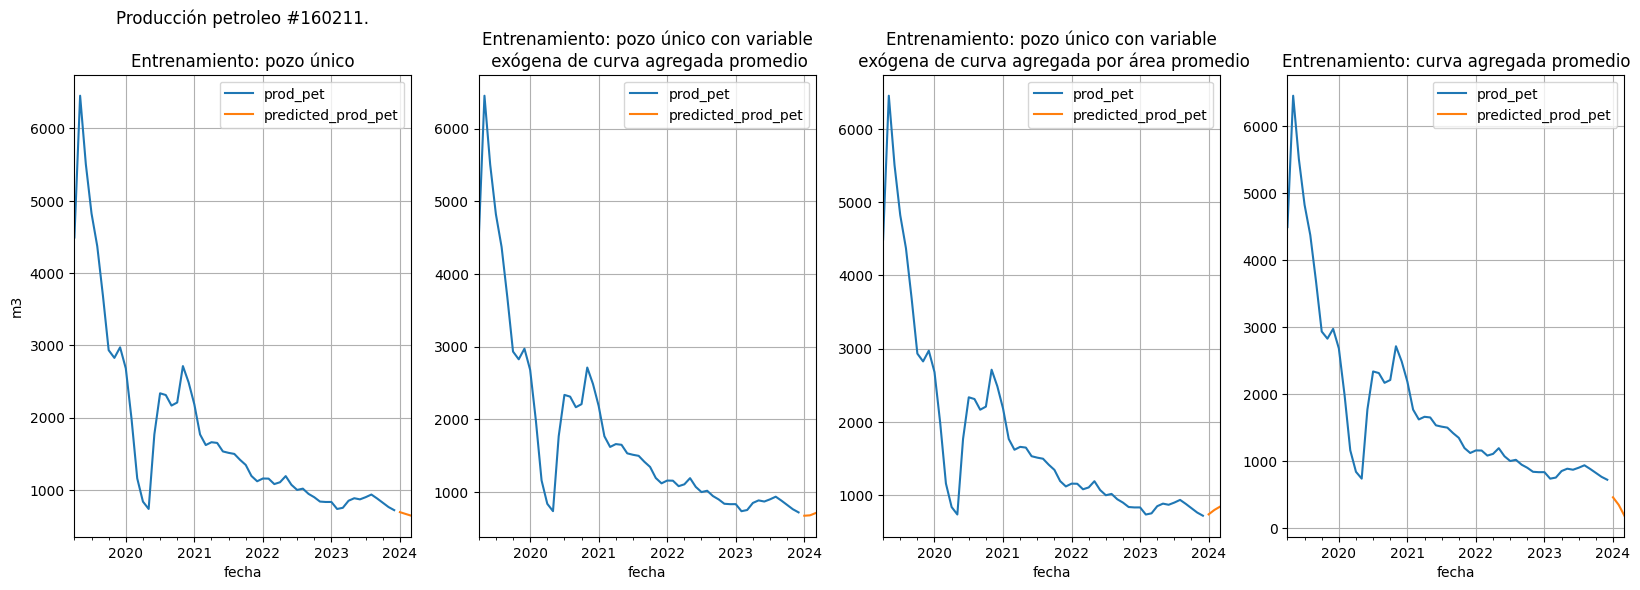


Running auto-arima on single well #160332 prediction

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=988.458, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=695.085, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(3,0,0)(0,0,0)[0

<ipython-input-21-5e103dc35849>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_mean_prod_norm["prod_pet"] = scaler.fit_transform(area_mean_prod_norm)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=630.739, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=629.533, Time=0.59 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=631.295, Time=0.70 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=633.555, Time=0.80 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=636.203, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=630.512, Time=0.72 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=633.294, Time=0.93 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=635.574, Time=0.88 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=630.769, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=631.328, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=633.098, Time=0.54 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=631.022, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   :

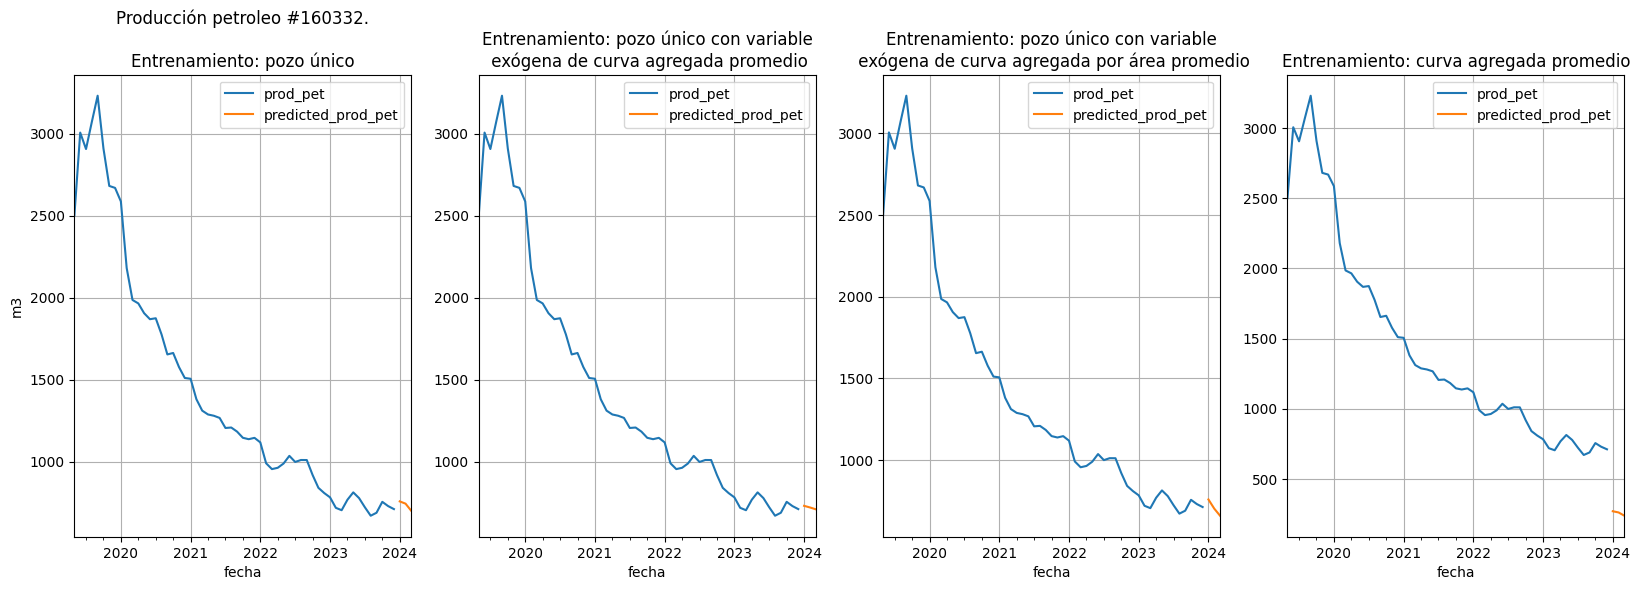


Running auto-arima on single well #160789 prediction

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=922.266, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=705.148, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.69 sec
 ARIMA(3,0,0)(0,0,0)[0

<ipython-input-21-5e103dc35849>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_mean_prod_norm["prod_pet"] = scaler.fit_transform(area_mean_prod_norm)



Running auto-arima on single well #160789 prediction with exogenous mean aggregate by area

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=652.635, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=647.014, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=646.747, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=645.200, Time=0.22 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=646.325, Time=0.36 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=647.524, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=649.044, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=647.216, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=648.593, Time=0.74 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(2,1,3)(0,0

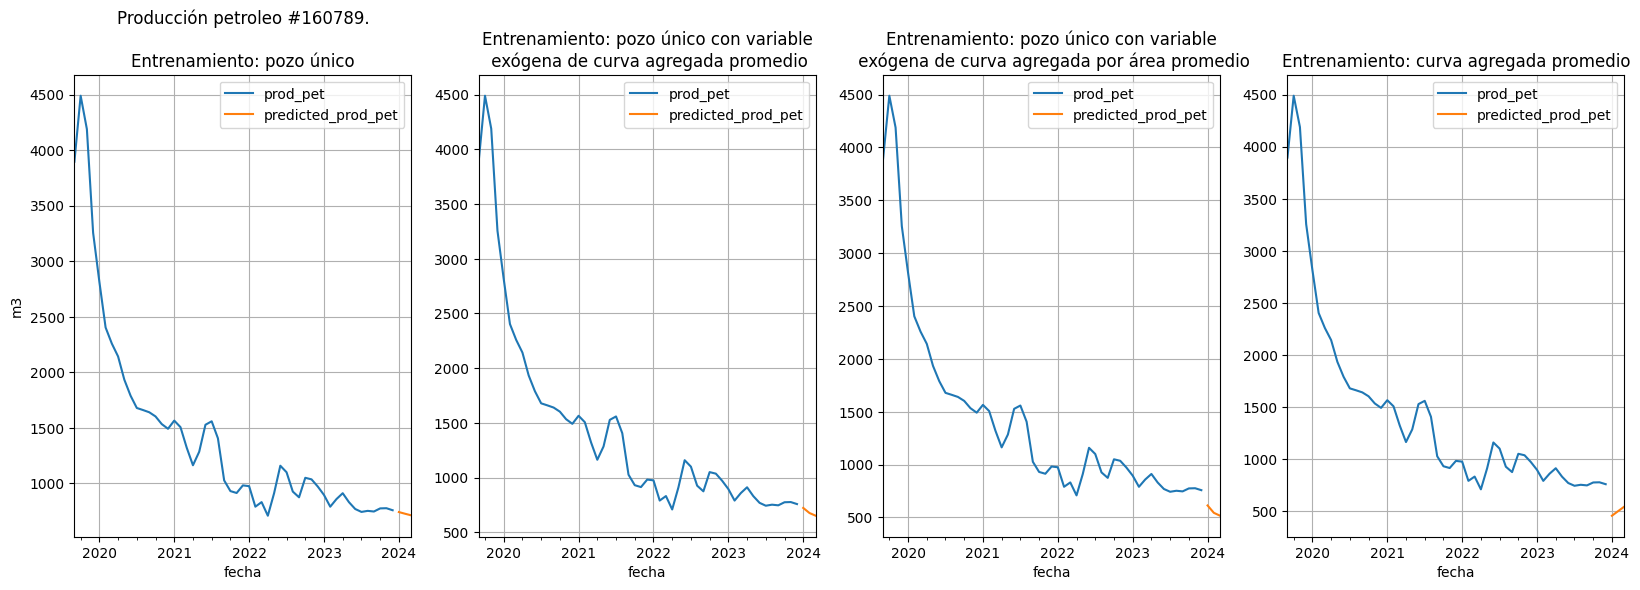


Running auto-arima on single well #160810 prediction

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=896.700, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=839.855, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=722.629, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=720.123, Time=0.18 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=720.875, Time=0.39 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=721.507, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA

<ipython-input-21-5e103dc35849>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_mean_prod_norm["prod_pet"] = scaler.fit_transform(area_mean_prod_norm)


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=691.099, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=688.522, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=686.453, Time=0.25 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=689.368, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=683.983, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=689.857, Time=0.30 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=687.830, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=686.001, Time=0.21 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=693.029, Time=0.38 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=689.564, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=687

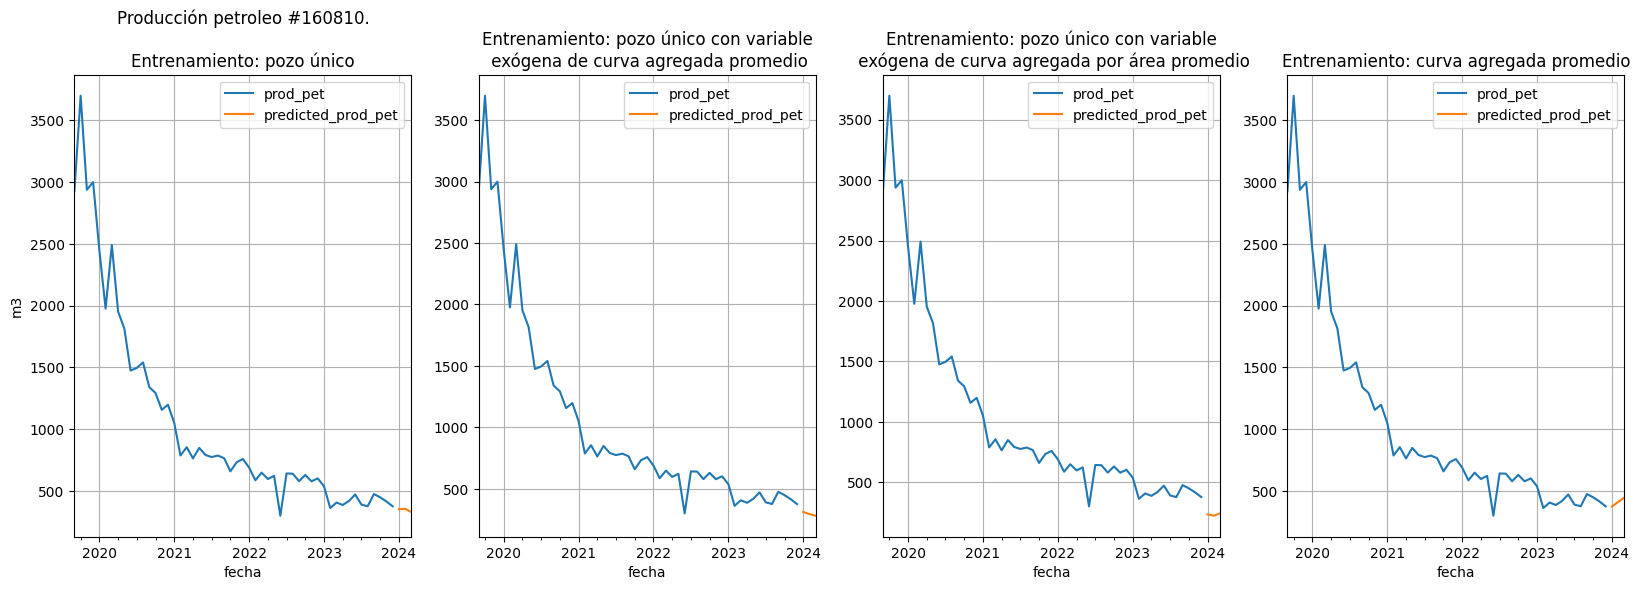


Running auto-arima on single well #160814 prediction

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=587.768, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=584.528, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=586.092, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=587.894, Time=0.16 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=585.800, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=586.557, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=585.768, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 A

<ipython-input-21-5e103dc35849>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_mean_prod_norm["prod_pet"] = scaler.fit_transform(area_mean_prod_norm)



Running auto-arima on single well #160814 prediction with exogenous mean aggregate by area

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=588.665, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=584.389, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=586.911, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=586.096, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   :

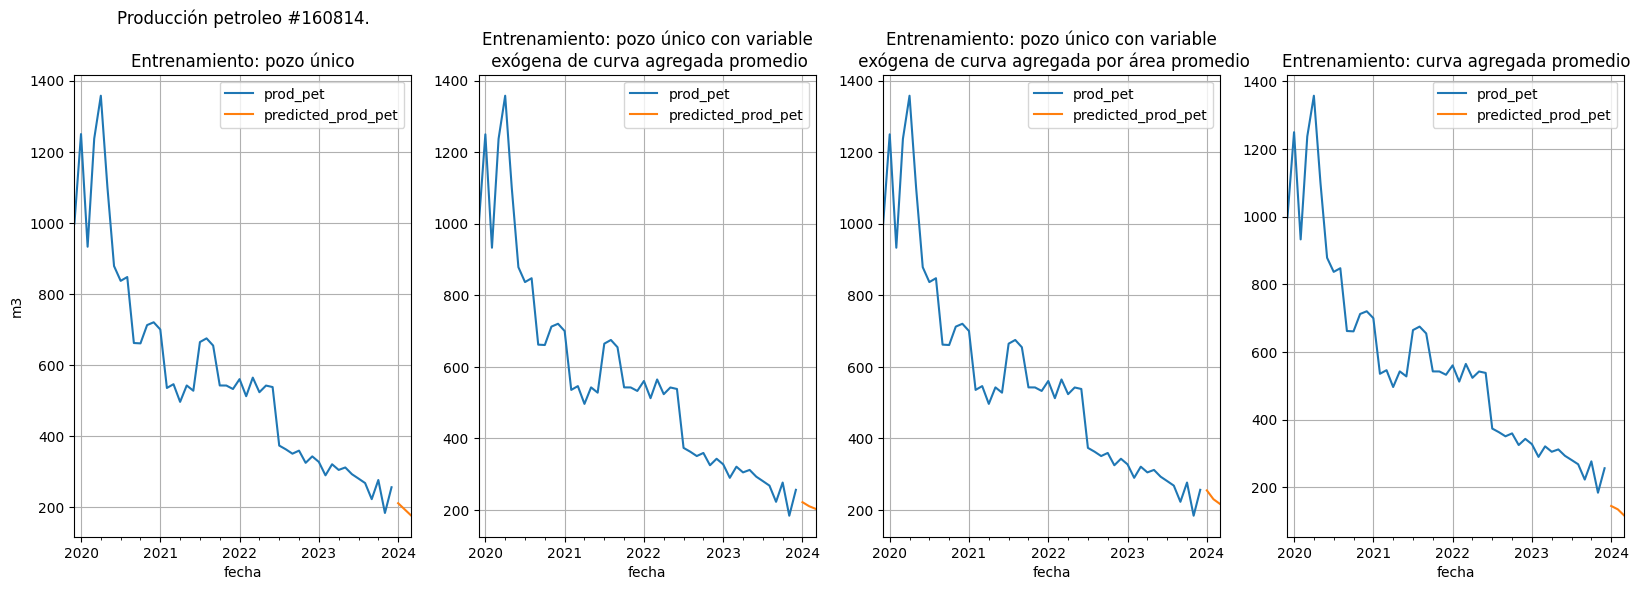


Running auto-arima on single well #161451 prediction

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=603.596, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=603.572, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=603.160, Time=0.43 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=604.226, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=601.665, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=603.504, Time=0.51 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=605.392, Time=0.32 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=607.473, Time=0.37 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=605.388, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=603.472, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time

<ipython-input-21-5e103dc35849>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_mean_prod_norm["prod_pet"] = scaler.fit_transform(area_mean_prod_norm)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=593.792, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=591.631, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=587.240, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=589.125, Time=0.19 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=591.122, Time=0.37 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=593.052, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=594.132, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=588.271, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=589.133, Time=0.61 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=591.123, Time=0.68 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=593.121, Time=0.48 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=592.371, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=589.129, Time=0.51 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=591.103, Time=0.85 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=593.132, Time=0.51 sec
 ARIMA(3,1,0)(0,0,0)[0] i

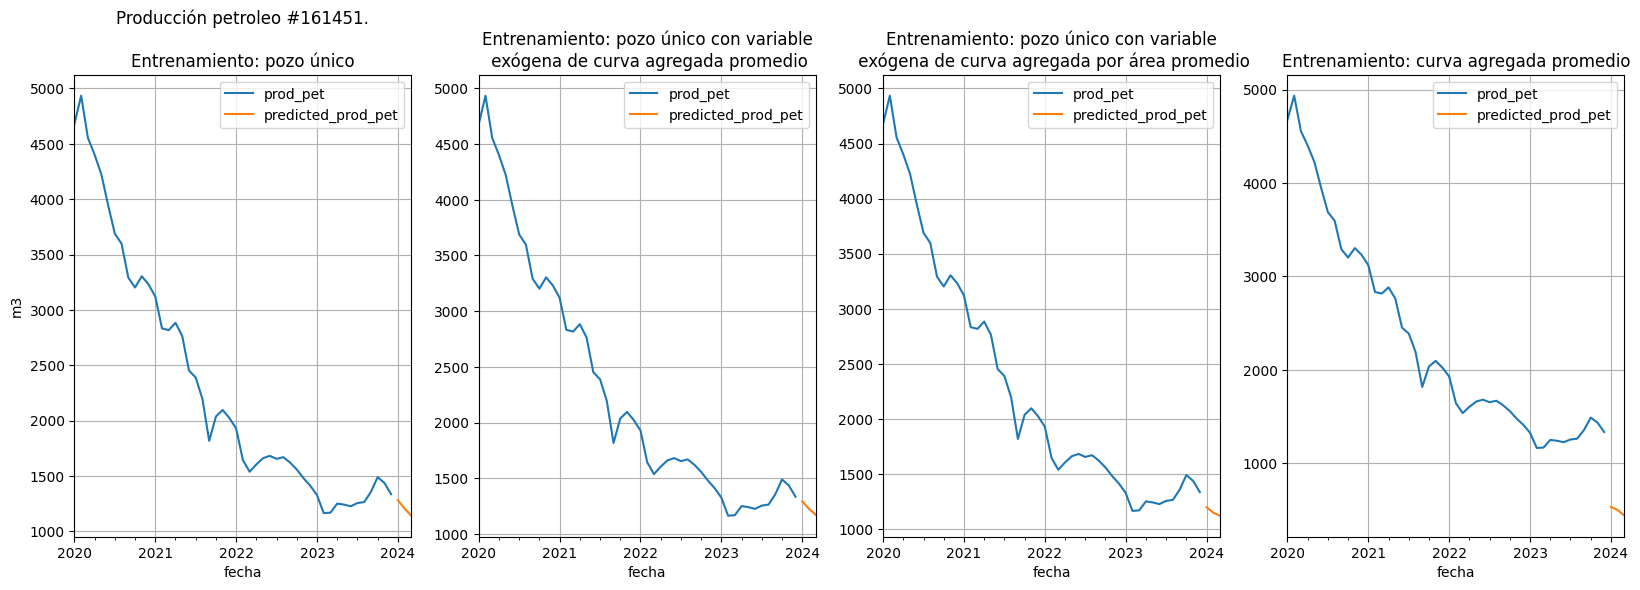


Running auto-arima on single well #162200 prediction

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=459.904, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=459.365, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=456.616, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=460.256, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=458.486, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(3,1

<ipython-input-21-5e103dc35849>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_mean_prod_norm["prod_pet"] = scaler.fit_transform(area_mean_prod_norm)


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=467.124, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=441.664, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=443.648, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=444.952, Time=0.20 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=443.652, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARI

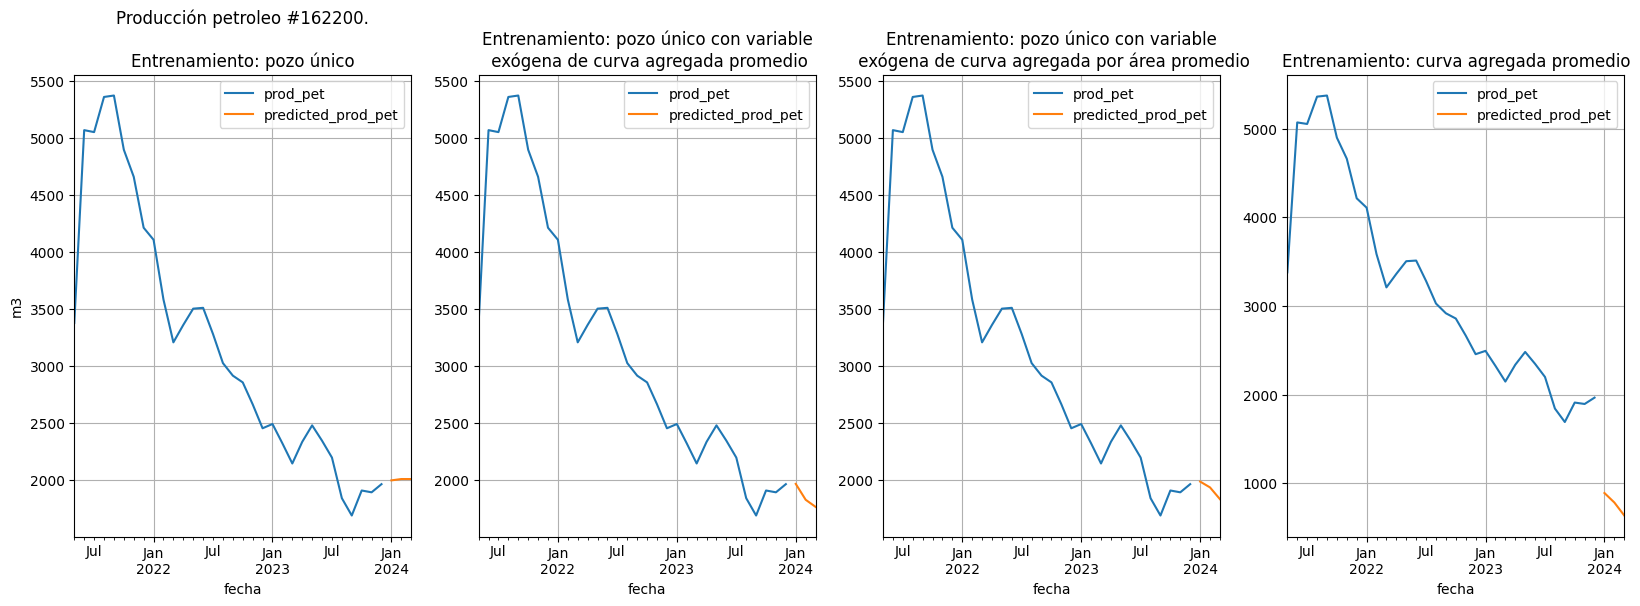


Running auto-arima on single well #162405 prediction

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=537.848, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=454.727, Time=0.46 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=0.69 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=460.656, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.80 sec
 ARIMA(3,0,0)(0,0,

<ipython-input-21-5e103dc35849>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_mean_prod_norm["prod_pet"] = scaler.fit_transform(area_mean_prod_norm)


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=418.141, Time=0.19 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=420.867, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=422.573, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=419.874, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=413.384, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=413.509, Time=0.26 sec


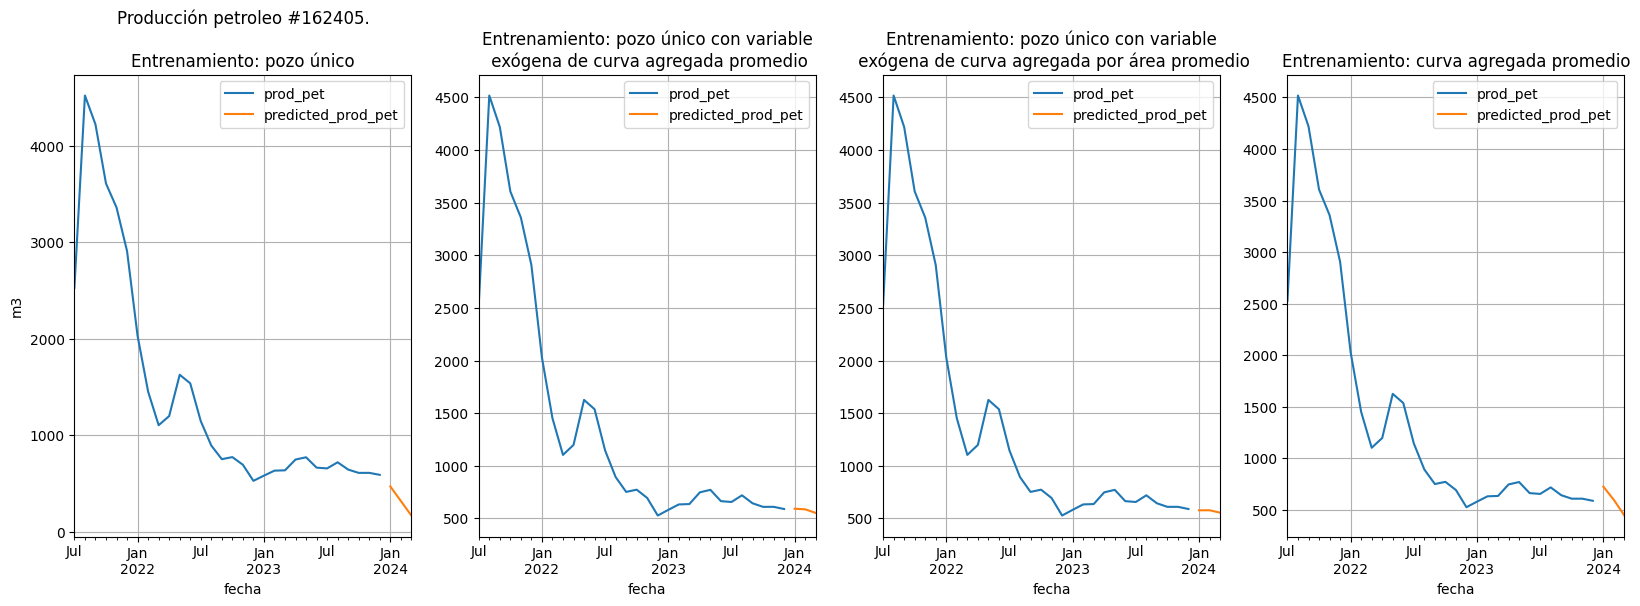


Running auto-arima on single well #162955 prediction

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=314.584, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=311.283, Time=0.38 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=315.502, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=311.371, Time=0.32 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(3,2,0)(

<ipython-input-21-5e103dc35849>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_mean_prod_norm["prod_pet"] = scaler.fit_transform(area_mean_prod_norm)


 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=294.415, Time=0.21 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=296.792, Time=0.13 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=297.537, Time=0.24 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(3,2,2

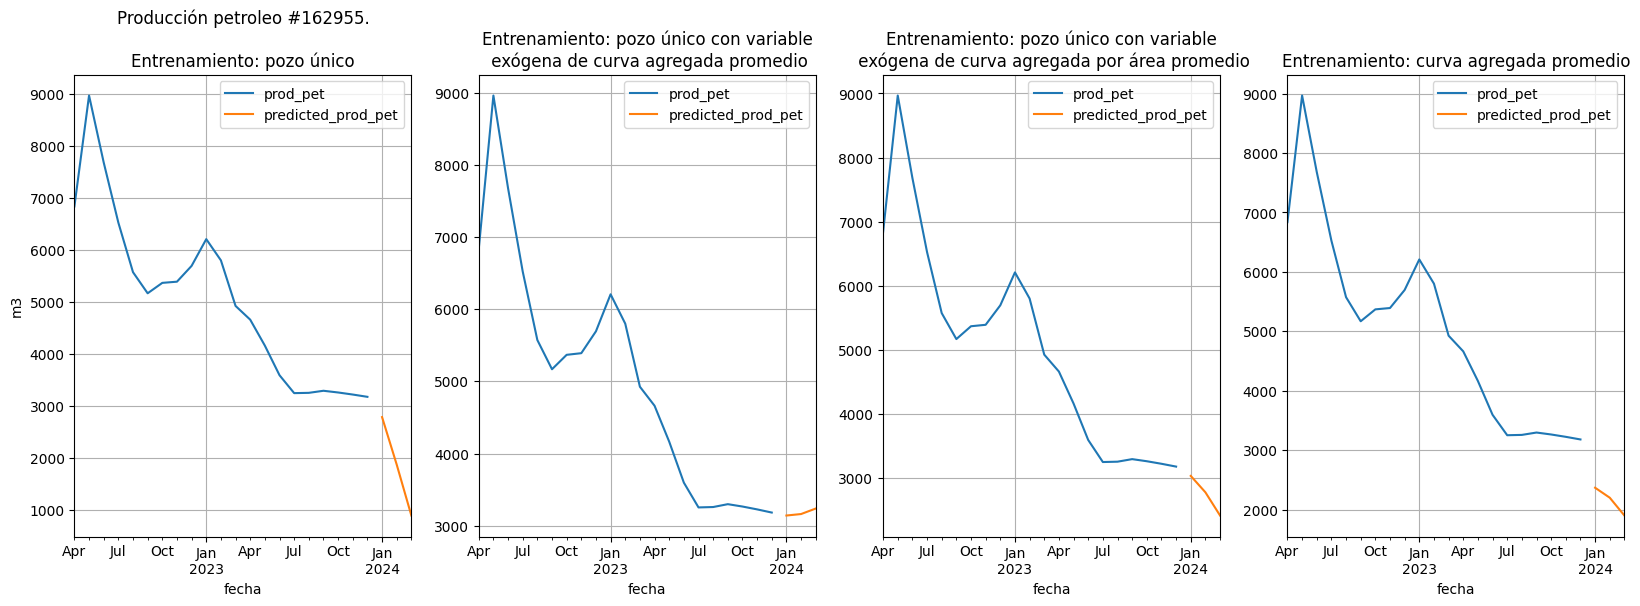


Running auto-arima on single well #163237 prediction

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=237.650, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=238.221, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=237.712, Time=0.44 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=236.691, Time=0.52 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(3,2,0)(

<ipython-input-21-5e103dc35849>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_mean_prod_norm["prod_pet"] = scaler.fit_transform(area_mean_prod_norm)


 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=229.470, Time=0.25 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=232.871, Time=0.16 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=235.752, Time=0.26 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=231.873, Time=0.18 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=232.316, Time=0.25 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=234.308, Time=0.26 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=233.078, Time=0.64 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=234.312, Time=0

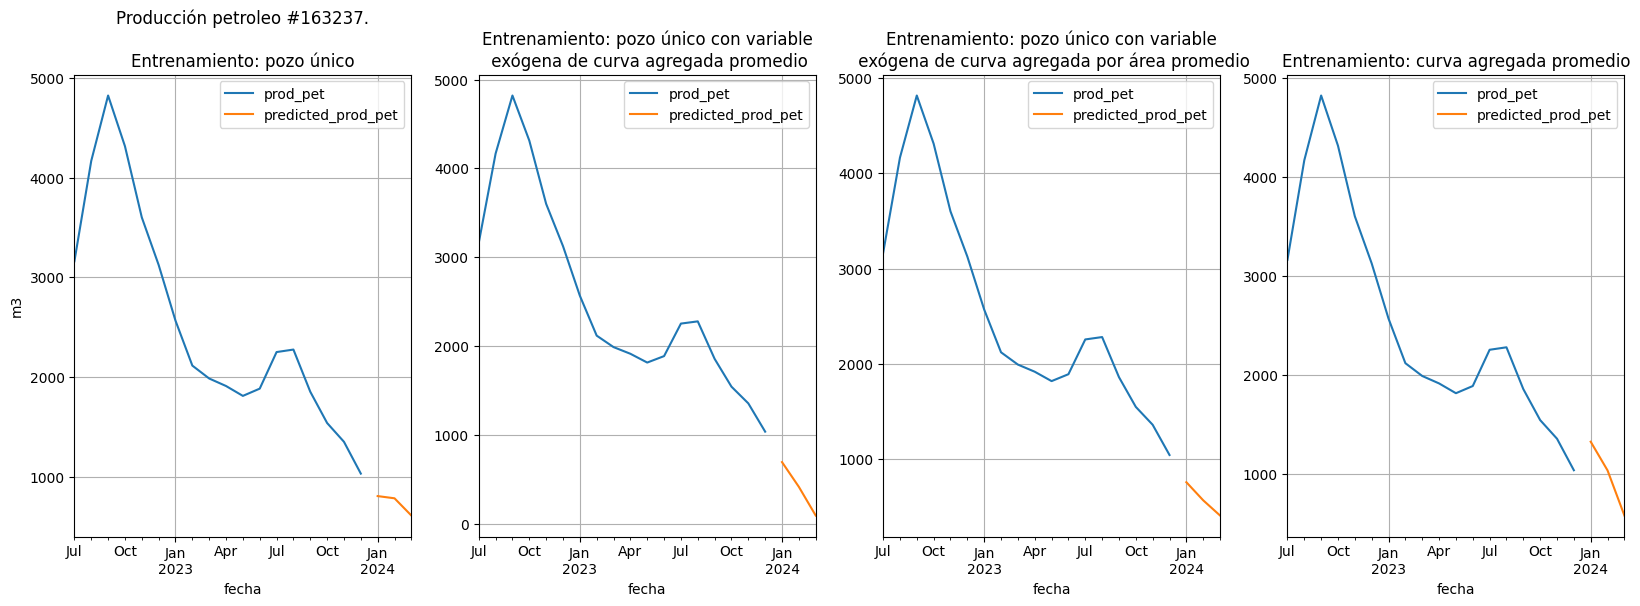


Running auto-arima on single well #163942 prediction

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=119.883, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=120.487, Time=0.13 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=120.814, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=121.382, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=123.870, Time=0.29 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=125.866, Time=0.33 sec

Best m

<ipython-input-21-5e103dc35849>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_mean_prod_norm["prod_pet"] = scaler.fit_transform(area_mean_prod_norm)


 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=115.682, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=116.687, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=115.800, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=123.629, Time=0.34 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=117.132, Time=0.39 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0] intercept
Total fit time: 4.

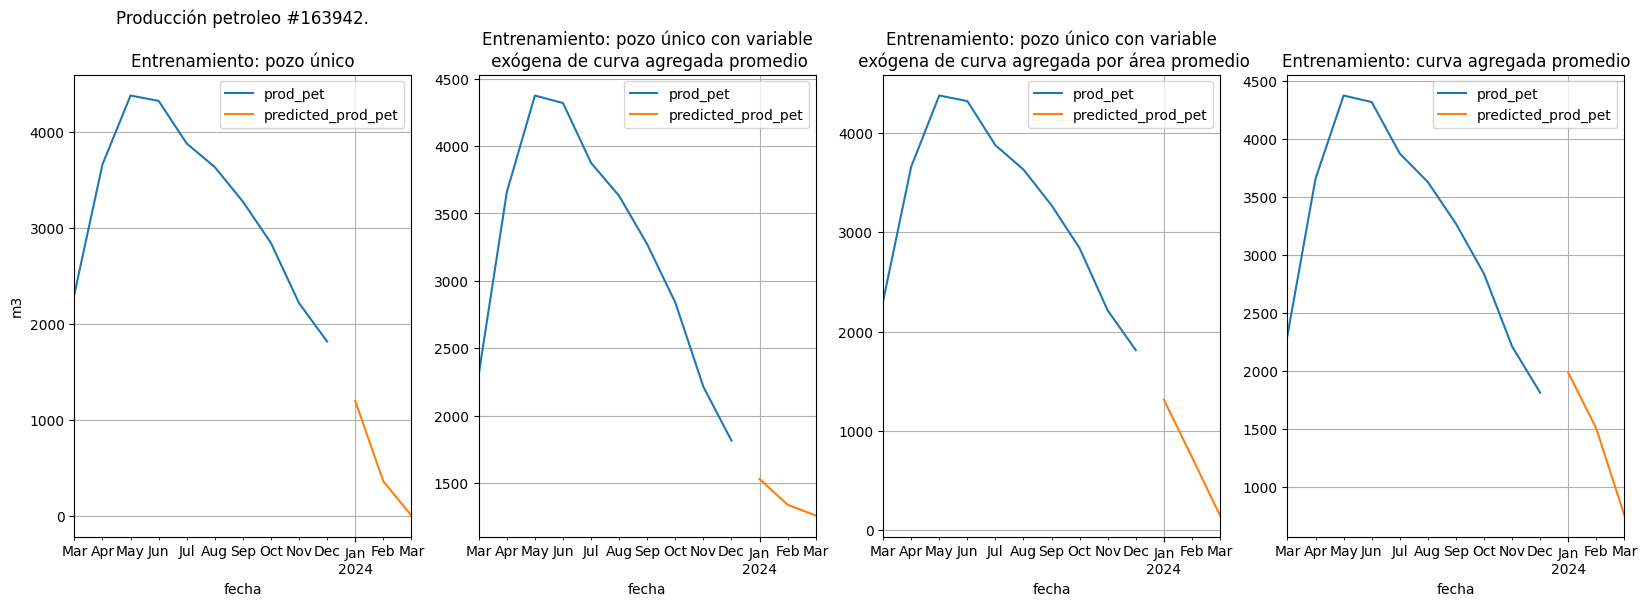

In [21]:
scaler = MinMaxScaler()
predicted_areas = []

predictions_single = pd.DataFrame()
predictions_total_mean = pd.DataFrame()
predictions_area_mean = pd.DataFrame()

wells_ids_to_predict = [158364, 160211, 160332, 160789, 160810, 160814, 161451, 162200, 162405, 162955, 163237, 163942]
for id in wells_ids_to_predict:
  well_prod = data[data["idpozo"] == id][['fecha', 'prod_pet']].set_index('fecha')

  # Plot results
  fig, axes = plt.subplots(nrows=1, ncols=4)
  fig.set_size_inches(20, 6)

  # Single well forecast ################################################################################################################################
  prod_single = well_prod.copy(deep=True)
  prod_single.index = pd.DatetimeIndex(prod_single.index).to_period('M')

  print(f"\nRunning auto-arima on single well #{id} prediction\n")
  fc, confint = predict_by_arima(prod_single, MONTHS_TO_PREDICT, debug=True)
  df = get_df_from_fc_and_confint(id, fc, confint)
  predictions_single = pd.concat([predictions_single, df], ignore_index=True)
  print("\n")

  prod_single.plot(ax=axes[0], title=f"Producción petroleo #{id}.\n\nEntrenamiento: pozo único", ylabel="m3")
  fc.plot(ax=axes[0])
  axes[0].grid(visible=True)

  # Single well forecast with exogenous aggregate mean ##################################################################################################
  print(f"\nRunning auto-arima on single well #{id} prediction with exogenous mean aggregate\n")
  total_mean_prod_norm = data.groupby(by="periodo")[["prod_pet"]].mean()
  total_mean_prod_norm["prod_pet"] = scaler.fit_transform(total_mean_prod_norm)
  fc, confint = predict_by_arima(prod_single, MONTHS_TO_PREDICT, total_mean_prod_norm, debug=True)
  df = get_df_from_fc_and_confint(id, fc, confint)
  predictions_total_mean = pd.concat([predictions_total_mean, df], ignore_index=True)
  print("\n")

  prod_single.plot(ax=axes[1], title=f"Entrenamiento: pozo único con variable\n exógena de curva agregada promedio")
  fc.plot(ax=axes[1])
  axes[1].grid(visible=True)

  # Single well forecast with exogenous aggregate mean by area #########################################################################################
  # Scale aggregate area curve to the same scale as current well
  area = data[data["idpozo"] == id].iloc[0]["areayacimiento"]
  if len(all_areas_mean_prods[area]) < (len(prod_single) + MONTHS_TO_PREDICT):
    all_areas_mean_prods[area] = predict_area_mean_prod(area, MONTHS_TO_PREDICT)
    predicted_areas.append(area)
  area_mean_prod_norm = all_areas_mean_prods[area][["prod_pet"]]
  area_mean_prod_norm["prod_pet"] = scaler.fit_transform(area_mean_prod_norm)

  print(f"\nRunning auto-arima on single well #{id} prediction with exogenous mean aggregate by area\n")
  fc, confint = predict_by_arima(prod_single, MONTHS_TO_PREDICT, area_mean_prod_norm, debug=True)
  df = get_df_from_fc_and_confint(id, fc, confint)
  predictions_area_mean = pd.concat([predictions_area_mean, df], ignore_index=True)
  print("\n")

  prod_single.plot(ax=axes[2], title=f"Entrenamiento: pozo único con variable\n exógena de curva agregada por área promedio")
  fc.plot(ax=axes[2])
  axes[2].grid(visible=True)

  # Aggregate well forecast #############################################################################################################################
  # Truncate aggregate curve to the same length as current well
  # Scale aggregate curve to the same scale as current well
  total_mean_prod = data.groupby(by="periodo")[["prod_pet"]].mean()
  well_prod_max = well_prod[['prod_pet']].max()[0]
  multiply_factor = well_prod_max / total_mean_prod.max()
  total_mean_prod_scaled = total_mean_prod * multiply_factor

  print(f"\nRunning auto-arima #{id} on mean aggregate prediction\n")
  fc, confint = predict_by_arima(total_mean_prod_scaled.head(len(well_prod)), MONTHS_TO_PREDICT, debug=True)
  print("\n")

  # Needed to go from "periodo" index to "fecha" index
  fc.index = well_prod.tail(MONTHS_TO_PREDICT).index.map(lambda i: i + pd.DateOffset(months=MONTHS_TO_PREDICT))
  well_prod.plot(ax=axes[3], title=f"Entrenamiento: curva agregada promedio")
  fc.plot(ax=axes[3])
  axes[3].grid(visible=True)

  plt.show()

# Geolocalización de los pozos, distinguidos por área de yacimiento

In [ ]:
import folium
import matplotlib
import seaborn as sns

# Wells unique ids with columns "latitude", "longitude", and "area"
wells_geo = pd.DataFrame()
wells_geo[["idpozo", "longitude", "latitude", "areayacimiento"]] = data.drop_duplicates(subset='idpozo')[["idpozo", "coordenadax", "coordenaday", "areayacimiento"]]
wells_geo.head()

# Create a folium map centered at an initial location
map_center = [wells_geo['latitude'].mean(), wells_geo['longitude'].mean()]
wells_geo_map = folium.Map(location=map_center, zoom_start=10)

# Get unique areas from the "area" column
areas = wells_geo[["areayacimiento"]].value_counts()
areas = areas[areas >= 10].index.get_level_values(0).to_list() # There are many areas with less than 10 wells. We dont want to have a lot of different markers


# markers_colors = ['red', 'blue', 'orange', 'green', 'purple', 'pink', 'cadetblue', 'darkred',
#                   'lightred', 'darkpurple', 'darkgreen', 'lightgreen', 'darkblue', 'lightblue']

markers_colors = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5'] #sns.color_palette(palette='tab20').as_hex() without greys
markers_shapes = ["circle", "triangle", "rectangle"]

def get_next_marker():
  try:
    get_next_marker.color_i += 1

    if get_next_marker.color_i >= len(markers_colors):
      get_next_marker.shape_i += 1
      get_next_marker.color_i = 0
      if get_next_marker.shape_i >= len(markers_shapes):
        get_next_marker.shape_i = 0

  except AttributeError:
    get_next_marker.color_i = 0
    get_next_marker.shape_i = 0

  return {"color": markers_colors[get_next_marker.color_i], "shape":markers_shapes[get_next_marker.shape_i]}

areas_markers = {}

for a in areas:
  areas_markers[a] = get_next_marker()

# Add markers for each well with custom colors
for index, row in wells_geo.iterrows():
  area = row['areayacimiento']
  area_marker = areas_markers.get(area, {"color": "gray", "shape": "circle"}) # Default to circle and gray if area not found
  area_shape = area_marker["shape"]
  area_color = area_marker["color"]
  tooltip = f"#{row['idpozo']} ({area})"
  fill_opacity = 0.6
  lat = row['latitude']
  lon = row['longitude']

  if area_shape == 'circle':
    folium.Circle(
        location=[lat, lon], radius=300, # meters
        color=area_color, fill=True, fill_color=area_color, fill_opacity=fill_opacity, tooltip=tooltip
    ).add_to(wells_geo_map)
  elif area_shape == 'rectangle':
    folium.Rectangle(
        bounds=[[lat - 0.0025, lon - 0.003], [lat + 0.0025, lon + 0.003]],
        color=area_color, fill=True, fill_color=area_color, fill_opacity=fill_opacity, tooltip=tooltip
    ).add_to(wells_geo_map)
  elif area_shape == 'triangle':
    folium.Polygon(
        locations=[[lat, lon + 0.004], [lat + 0.004, lon], [lat, lon - 0.004]], number_of_sides=3,
        color=area_color, fill=True, fill_color=area_color, fill_opacity=fill_opacity, tooltip=tooltip
    ).add_to(wells_geo_map)

# Save the map to an HTML file
# wells_geo_map.save("/content/drive/MyDrive/Trabajo profesional/Code/data/wells_geo_map.html")

# Display
wells_geo_map

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
predictions_single.sort_values(by=['fecha', 'idpozo'], ascending=True, inplace=True)
predictions_single.reset_index(drop=True, inplace=True)
predictions_single.to_csv(BASE_DRIVE_PATH + "/Code/data/predictions/arima_single" + ".csv")

In [ ]:
predictions_total_mean.sort_values(by=['fecha', 'idpozo'], ascending=True, inplace=True)
predictions_total_mean.reset_index(drop=True, inplace=True)
predictions_total_mean.to_csv(BASE_DRIVE_PATH + "/Code/data/predictions/arima_total_mean" + ".csv")

In [ ]:
predictions_area_mean.sort_values(by=['fecha', 'idpozo'], ascending=True, inplace=True)
predictions_area_mean.reset_index(drop=True, inplace=True)
predictions_area_mean.to_csv(BASE_DRIVE_PATH + "/Code/data/predictions/arima_area_mean" + ".csv")